In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import meshio
from pathlib import Path


import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap, random
import optax
from tqdm.auto import tqdm
from typing import Callable
import pickle
import equinox as eqx

import os

from triangular_transport.flows.flow_trainer import (
    NNTrainer,
)

from triangular_transport.flows.interpolants import (
    linear_interpolant,
    linear_interpolant_der,
    trig_interpolant,
    trig_interpolant_der,
    sigmoid_interpolant,
    sigmoid_interpolant_der,
)
from triangular_transport.flows.loss_functions import vec_field_loss
from triangular_transport.networks.flow_networks import MLP, MLP_Triangular
from triangular_transport.flows.methods.utils import UnitGaussianNormalizer
from triangular_transport.flows.dataloaders import gaussian_reference_sampler

import json
import h5py

import argparse

plt.style.use("ggplot")

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
jax.config.update("jax_default_device", jax.devices()[1])

In [2]:
SAVE_TRIAL = False

In [3]:
def read_data_h5(path="data_grid.h5"):
    with h5py.File(path, "r") as f:
        targets = f["/target"][...]
        data = f["/data"][...]
    return targets, data

In [4]:
with open("ppoisson_box.yaml") as fid:
    inargs = yaml.full_load(fid)

utrue = np.load("training_dataset/true_param_grid.npy")
ytrue = np.load("training_dataset/true_state.npy")
targets, yobs = read_data_h5()

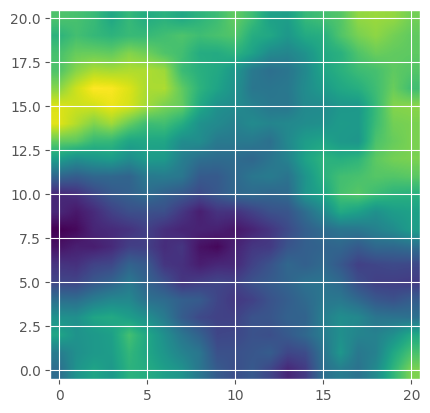

In [8]:
plt.imshow(utrue[:, :, 0], origin="lower", interpolation="bilinear")

In [12]:
no_samples = inargs["MCMC"]["nsamples"] - inargs["MCMC"]["burnin"]
hmala_samps = np.load("training_dataset/hmala_samples_grid.npy").reshape(
    no_samples, 21, 21, 3, order="F"
)
hmala0 = np.load("training_dataset/chain_00/hmala_samples_grid.npy").reshape(
    no_samples, 21, 21, 3, order="F"
)
hmala1 = np.load("training_dataset/chain_01/hmala_samples_grid.npy").reshape(
    no_samples, 21, 21, 3, order="F"
)
hmala2 = np.load("training_dataset/chain_02/hmala_samples_grid.npy").reshape(
    no_samples, 21, 21, 3, order="F"
)
hmala3 = np.load("training_dataset/chain_03/hmala_samples_grid.npy").reshape(
    no_samples, 21, 21, 3, order="F"
)
hmala_mean = np.mean(hmala_samps, axis=0)
hmala_var = np.var(hmala_samps, axis=0)

hmala0_mean = np.mean(hmala0, axis=0)
hmala0_var = np.var(hmala0, axis=0)

hmala1_mean = np.mean(hmala1, axis=0)
hmala1_var = np.var(hmala1, axis=0)

hmala2_mean = np.mean(hmala2, axis=0)
hmala2_var = np.var(hmala2, axis=0)

hmala3_mean = np.mean(hmala3, axis=0)
hmala3_var = np.var(hmala3, axis=0)

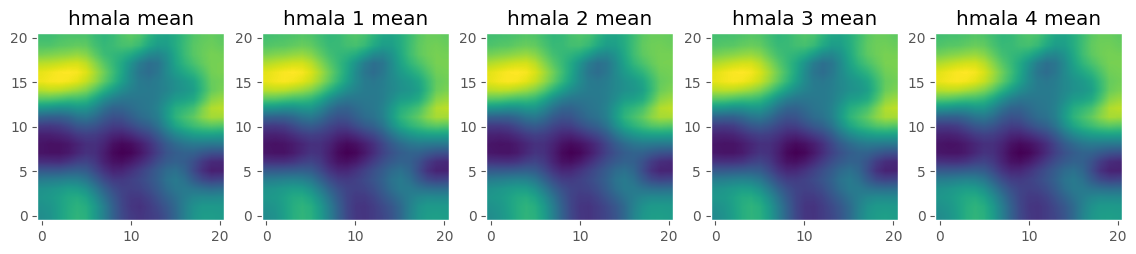

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(14, 14))
means_plot = [hmala_mean, hmala0_mean, hmala1_mean, hmala2_mean, hmala3_mean]

for i in range(5):
    ax[i].imshow(means_plot[i][:, :, 0], origin="lower", interpolation="bilinear")
    ax[i].grid(False)
    if i == 0:
        ax[i].set_title("hmala mean")
    else:
        ax[i].set_title(f"hmala {i} mean")

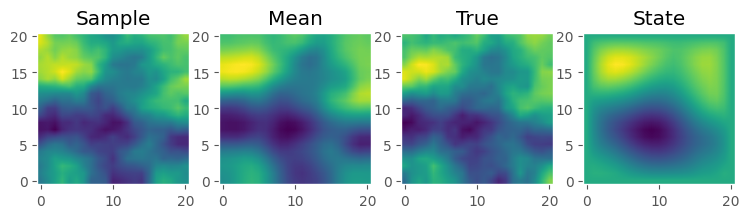

In [6]:
one_samp = hmala_samps[-1]
layer_idx = 0
bottom_samp = one_samp[:, :, layer_idx]

fig, ax = plt.subplots(1, 4, figsize=(9, 9))

ax[0].imshow(bottom_samp, origin="lower", interpolation="bilinear")
ax[0].set_title("Sample")
ax[0].grid(False)

ax[1].imshow(hmala_mean[:, :, layer_idx], origin="lower", interpolation="bilinear")
ax[1].set_title("Mean")
ax[1].grid(False)

ax[2].imshow(utrue[:, :, layer_idx], origin="lower", interpolation="bilinear")
ax[2].set_title("True")
ax[2].grid(False)

ax[3].imshow(ytrue[:, :, layer_idx], origin="lower", interpolation="bilinear")
ax[3].set_title("State")
ax[3].grid(False)

In [ ]:
train_dim = 50000
nx = ny = 21
nz = 3
flat_length = nx * ny
ys = (np.load("training_dataset/solutions_grid.npy"))[:train_dim]
us = (np.load("training_dataset/parameters_grid.npy"))[:train_dim, :, :, 0].reshape(
    train_dim, flat_length
)

# us_ref = (np.load("training_dataset/parameters.npy"))[
#     (train_dim + 1) : (train_dim * 2 + 1), :, :, 0
# ].reshape(train_dim, flat_length)
us_ref = us.copy()
np.random.shuffle(us_ref)

# us_test = (np.load("training_dataset/parameters.npy"))[
#     (train_dim * 2 + 1) : (train_dim * 2 + 20001), :, :, 0
# ].reshape(no_samples, flat_length)
us_test = (np.load("training_dataset/parameters_grid.npy"))[
    train_dim:, :, :, 0
].reshape(20000, flat_length)
np.random.shuffle(us_test)

ys_normalizer = UnitGaussianNormalizer(ys)
# us_normalizer = UnitGaussianNormalizer(us)
ys_normalized = ys_normalizer.encode()
# us_normalized = us_normalizer.encode()

# us_ref_normalized = us_normalizer.encode(us_ref)
# us_test_normalized = us_normalizer.encode(us_test)

2025-09-12 17:51:32.030001: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
mean_us = us.mean(axis=0)
X = us - mean_us

U, S, Vt = np.linalg.svd(us / (np.sqrt(train_dim - 1)), full_matrices=False)
V = Vt.T

expl_var = (S**2) / (S**2).sum()
k = np.searchsorted(np.cumsum(expl_var), 0.98) + 1
# k = 30

V = V[:, :k]
S = S[:k]

alpha = 0.1


def pca_encode(b):
    # whitened coeffs z
    return (b - mean_us) @ V / S


def pca_decode(z):
    # undo whitening
    return mean_us + (z * S) @ V.T

In [9]:
us_pca = pca_encode(us)
us_ref_pca = pca_encode(us_ref)
us_test_pca = pca_encode(us_test)

train_data = jnp.hstack([ys_normalized, us_pca])
x0_data = jnp.hstack([ys_normalized, us_ref_pca])
# train_data = jnp.hstack([ys_normalized, us])
# x0_data = jnp.hstack([ys_normalized, us_ref])

In [11]:
key = random.PRNGKey(seed=42)
key1, key2 = random.split(key=key, num=2)
batch_size = 128
steps = 50000
print_every = 5000
yu_dimension = (100, k.item())
dim = yu_dimension[0] + yu_dimension[1]
hidden_layer_list = [512] * 4
model = MLP(
    key=key2,
    dim=dim,
    time_varying=True,
    w=hidden_layer_list,
    num_layers=len(hidden_layer_list) + 1,
    activation_fn=jax.nn.gelu,  # GeLU worked well
)
# model = MLP_FF(
#     key=key2,
#     dim=dim,
#     out_dim=None,
#     num_layers=5,
#     w=[256],
#     activation_fn=jax.nn.gelu,
#     time_varying=True,
#     rff_dim=512,
#     rff_sigma=15.0,
#     rff_include_input=True,
#     rff_time=True,
# )
# schedule = optax.linear_schedule(
#     init_value=1e-3,          # Starting learning rate
#     end_value=3e-4,           # Final learning rate
#     transition_steps=2000     # Number of steps over which to linearly increase
# )
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=3e-4,
    warmup_steps=2_000,
    decay_steps=steps,
    end_value=1e-5,
)
# lr=1e-9
optimizer = optax.adamw(schedule)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(schedule))
interpolant = linear_interpolant
interpolant_der = linear_interpolant_der
interpolant_args = {"t": None, "x1": None, "x0": None}

In [12]:
trainer = NNTrainer(
    target_density=None,
    model=model,
    optimizer=optimizer,
    interpolant=interpolant,
    interpolant_der=interpolant_der,
    reference_sampler=gaussian_reference_sampler,
    loss=vec_field_loss,
    interpolant_args=interpolant_args,
    yu_dimension=yu_dimension,
)
trainer.train(
    train_data=train_data,
    train_dim=train_dim,
    batch_size=batch_size,
    steps=steps,
    x0_data=x0_data,
);

Training neural network


  0%|          | 0/50000 [00:00<?, ?it/s]

step = 0, train_loss = 0.21513009071350098
step = 5000, train_loss = -38.21169662475586
step = 10000, train_loss = -61.63127899169922
step = 15000, train_loss = -68.60173034667969
step = 20000, train_loss = -76.86442565917969
step = 25000, train_loss = -72.45108032226562
step = 30000, train_loss = -78.81019592285156
step = 35000, train_loss = -80.33882904052734
step = 40000, train_loss = -77.12448120117188
step = 45000, train_loss = -82.61881256103516
step = 49999, train_loss = -77.41787719726562


In [18]:
ytrue_flat = yobs.copy()
ytrue_flat_normalized = ys_normalizer.encode(ytrue_flat)
ys_test_normalized = jnp.full(
    (no_samples, ytrue_flat_normalized.shape[0]), ytrue_flat_normalized
)
x0_test = jnp.hstack([ys_test_normalized, us_test_pca])
# x0_test = jnp.hstack([ys_test_normalized, us_test])

cond_values = [tuple(ytrue_flat_normalized)]
cond_samples = trainer.conditional_sample(
    cond_values=cond_values, x0_cond=x0_test, nsamples=20000
)
all_samples = cond_samples[0][0]

u_samples = all_samples[:, yu_dimension[0] :]
u_samples = pca_decode(u_samples)
u_samples = u_samples.reshape(no_samples, nx, ny, order="C")
u_means = jnp.mean(u_samples, axis=0)
u_var = jnp.var(u_samples, axis=0)

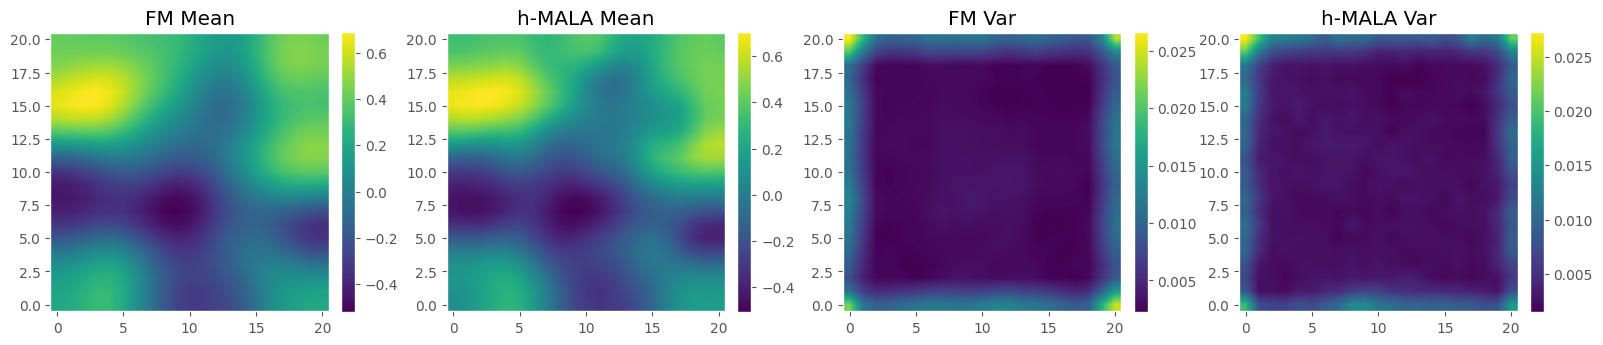

In [19]:
layer_idx = 0
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

im0 = ax[0].imshow(u_means, origin="lower", interpolation="bilinear")
ax[0].set_title("FM Mean")
ax[0].grid(False)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(
    hmala_mean[:, :, layer_idx], origin="lower", interpolation="bilinear"
)
ax[1].set_title("h-MALA Mean")
ax[1].grid(False)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(u_var, origin="lower", interpolation="bilinear")
ax[2].set_title("FM Var")
ax[2].grid(False)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

im3 = ax[3].imshow(hmala_var[:, :, layer_idx], origin="lower", interpolation="bilinear")
ax[3].set_title("h-MALA Var")
ax[3].grid(False)
fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

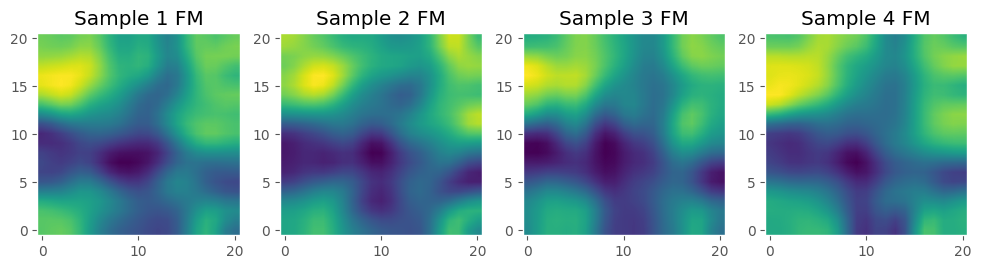

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(12, 12))

for i in range(4):
    ax[i].imshow(
        u_samples[np.random.choice(20000)], origin="lower", interpolation="bilinear"
    )
    ax[i].grid(False)
    ax[i].set_title(f"Sample {i + 1} FM")

In [ ]:
eps = 0.01
t = random.uniform(key2, shape=(batch_size, 1))
x1 = train_data[:batch_size, :]
x0 = x0_data[:batch_size, :]
Ivals = interpolant(t, x1, x0)
It_vals = interpolant_der(t, x1, x0)
Ieps_vals = (interpolant(t + eps, x1, x0) - interpolant(t - eps, x1, x0)) / (2 * eps)

In [ ]:
bu = vmap(trainer.model)(jnp.hstack([t, Ivals]))
uw = It_vals

corr = jnp.mean(
    jnp.sum(bu * uw, axis=1)
    / (1e-8 + jnp.linalg.norm(bu, axis=1) * jnp.linalg.norm(uw, axis=1))
)
scale = jnp.mean(
    jnp.sum(bu * uw, axis=1) / (1e-8 + jnp.sum(bu * bu, axis=1))
)  # least-squares gain from bu→uw
print("corr ~ [0..1], scale ~ 1 ideal:", corr, scale)

corr ~ [0..1], scale ~ 1 ideal: 0.52503747 1.0303866


In [ ]:
t_list = [0.0, 0.25, 0.5, 0.75, 1.0]
grad_norm_list = []
for t in t_list:
    grad_norm_list.append(
        jnp.sum(
            trainer.vmap_model(
                jnp.hstack([jnp.full(fill_value=t, shape=(batch_size, 1)), Ivals])
            )
            ** 2,
            axis=1,
        )
    )

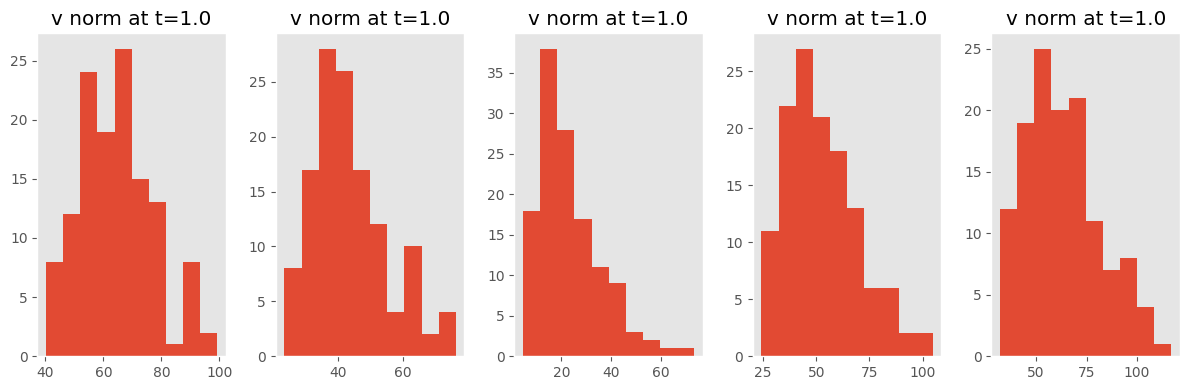

In [ ]:
fig, ax = plt.subplots(1, len(t_list), figsize=(12, 4))
for i, grad_norm in enumerate(grad_norm_list):
    ax[i].hist(grad_norm)
    ax[i].grid(False)
    ax[i].set_title(f"v norm at t={t}")
plt.tight_layout()

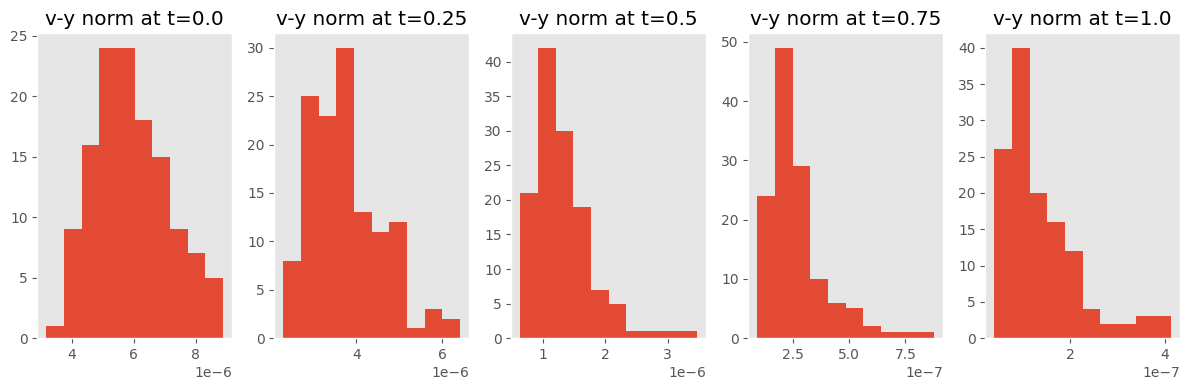

In [ ]:
t_list = [0.0, 0.25, 0.5, 0.75, 1.0]
grad_norm_list = []
for t in t_list:
    grad_norm_list.append(
        jnp.sum(
            trainer.vmap_model(
                jnp.hstack([jnp.full(fill_value=t, shape=(batch_size, 1)), Ivals])
            )[:, : yu_dimension[0]]
            ** 2,
            axis=1,
        )
    )

fig, ax = plt.subplots(1, len(t_list), figsize=(12, 4))
for i, grad_norm in enumerate(grad_norm_list):
    ax[i].hist(grad_norm)
    ax[i].grid(False)
    ax[i].set_title(f"v-y norm at t={t_list[i]}")
plt.tight_layout()

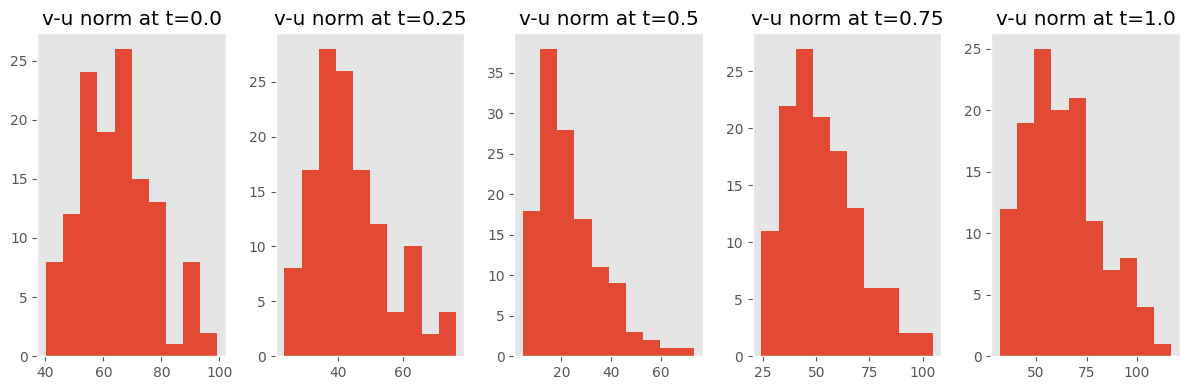

In [ ]:
t_list = [0.0, 0.25, 0.5, 0.75, 1.0]
grad_norm_list = []
for t in t_list:
    grad_norm_list.append(
        jnp.sum(
            trainer.vmap_model(
                jnp.hstack([jnp.full(fill_value=t, shape=(batch_size, 1)), Ivals])
            )[:, yu_dimension[0] :]
            ** 2,
            axis=1,
        )
    )

fig, ax = plt.subplots(1, len(t_list), figsize=(12, 4))
for i, grad_norm in enumerate(grad_norm_list):
    ax[i].hist(grad_norm)
    ax[i].grid(False)
    ax[i].set_title(f"v-u norm at t={t_list[i]}")
plt.tight_layout()

In [ ]:
def estimate_gamma_star(model, t, Ivals, uw):
    bu = vmap(model)(jnp.hstack([t, Ivals]))
    num = jnp.mean(jnp.sum(bu * uw, axis=1))
    denom = jnp.mean(jnp.sum(bu**2, axis=1)) + 1e-12
    return num / denom


t = random.uniform(key2, shape=(25000, 1))
x1 = train_data[:25000, :]
x0 = x0_data[:25000, :]
Ivals = interpolant(t, x1, x0)
It_vals = interpolant_der(t, x1, x0)
gamma_star = estimate_gamma_star(trainer.model, t, Ivals, It_vals)

In [ ]:
# x batch is [y, u] in that order; yu_dimension = (dim_y, dim_u)
dy, du = yu_dimension

# bu_full: predicted full velocity on [y,u] at some fixed t (or your usual batch of t's)
# If your model outputs only u (common in your code), skip this and go straight to step 2 below.
bu_full = jax.vmap(trainer.model)(jnp.hstack([t, Ivals]))  # shape (B, dy+du) or (B, du)

if bu_full.shape[1] == dy + du:
    v_y = bu_full[:, :dy]
    v_u = bu_full[:, dy:]
    Ey = jnp.mean(jnp.sum(v_y**2, axis=1))
    Eu = jnp.mean(jnp.sum(v_u**2, axis=1))
    print("Energy ratio Ey/(Ey+Eu):", float(Ey / (Ey + Eu + 1e-12)))


Energy ratio Ey/(Ey+Eu): 4.240038009584168e-08


In [ ]:
class Scaled(eqx.Module):
    base: eqx.Module
    gamma: jnp.ndarray

    def __init__(self, base, gamma):
        self.base = base
        self.gamma = jnp.asarray(gamma)

    def __call__(self, z):
        return self.gamma * self.base(z)


class ZeroY(eqx.Module):
    base: eqx.Module
    dy: int

    def __init__(self, base, dy):
        self.base, self.dy = base, dy

    def __call__(self, z):
        v = self.base(z)  # shape (dy+du,)
        return jnp.concatenate([jnp.zeros(self.dy, v.dtype), v[self.dy :]])


cal_model = Scaled(trainer.model, gamma_star)
zeroy_model = ZeroY(trainer.model, dy)

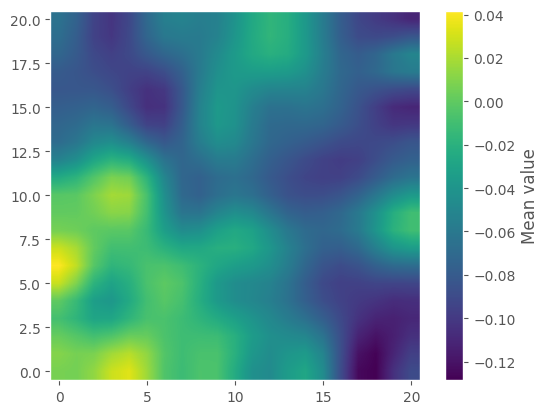

In [ ]:
from triangular_transport.flows.ode_solvers import sample_trajectory_nosave_ODE

all_samps = sample_trajectory_nosave_ODE(
    vmap_model=vmap(cal_model),
    X0=x0_test,
)
u_samps = all_samps[:, yu_dimension[0] :]
u_samps = pca_decode(u_samps).reshape(20000, nx, ny)
fig, ax = plt.subplots()
im = ax.imshow(jnp.mean(u_samps, axis=0), origin="lower", interpolation="bilinear")
ax.grid(False)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Mean value")
plt.show()

In [ ]:
if SAVE_TRIAL:
    np.save(
        "fm_samples_post.npy",
        u_samples[np.random.choice(20000, (300,))].reshape(300, flat_length, order="C"),
    )

In [160]:
fm_forward = np.load("training_dataset/fm_forward_obs_post.npy")

In [161]:
mse_vals = []
r = fm_forward - yobs
mean_res = r.mean(axis=0)
var_res = r.var(axis=0, ddof=1)

In [162]:
sigma = (0.005) ** 0.5
z = r / sigma
print("avg standardized var over sensors: ", np.mean(z.var(axis=0, ddof=1)))

avg standardized var over sensors:  0.13743400157983346


Text(0.5, 1.0, 'Var - FM')

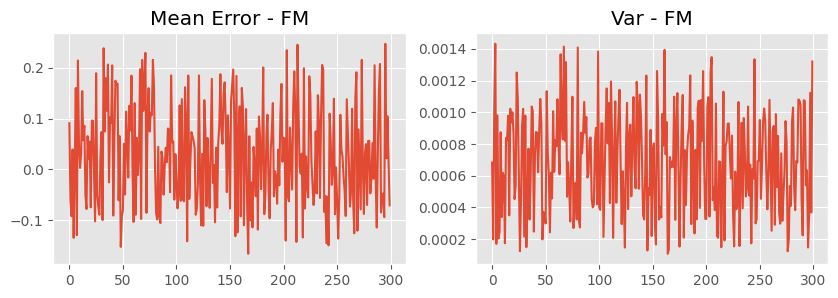

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(mean_res)
ax[0].set_title("Mean Error - FM")

ax[1].plot(var_res)
ax[1].set_title("Var - FM")

In [164]:
print(f"Average mean residual: {np.mean(mean_res)}")
print(f"Average variance residual: {np.mean(var_res)}")

Average mean residual: 0.029051301661168125
Average variance residual: 0.0006871700078991672


In [1]:
import numpy as np

In [ ]:
(np.pi / 2) * (-np.sin(np.pi / 8) + np.cos(np.pi / 8)) / (
    np.cos(np.pi / 8) + np.sin(np.pi / 8)
)

np.float64(0.6506451422842864)

In [3]:
def vel_y_trig(t):
    return (
        (np.pi / 2)
        * (-np.sin((np.pi / 2) * t) + np.cos((np.pi / 2) * t))
        / (np.cos((np.pi / 2) * t) + np.sin((np.pi / 2) * t))
    )

In [7]:
vel_y_trig(1 / 4)

np.float64(0.6506451422842864)

In [8]:
vel_y_trig(3 / 4)

np.float64(-0.6506451422842864)